In [1]:
import numpy as np

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output

class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

class Activation_Linear:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0., clipnorm=1.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.clipnorm = clipnorm

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.momentum * layer.weight_cache - self.current_learning_rate * layer.dweights
        layer.bias_cache = self.momentum * layer.bias_cache - self.current_learning_rate * layer.dbiases

        norm = np.sqrt(np.sum(layer.dweights**2) + np.sum(layer.dbiases**2))
        if norm > self.clipnorm:
            scale = self.clipnorm / (norm + 1e-8)
            layer.dweights *= scale
            layer.dbiases *= scale

        layer.weights += layer.weight_cache
        layer.biases += layer.bias_cache

    def post_update_params(self):
        self.iterations += 1


class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., beta_1=0.9, beta_2=0.999, epsilon=1e-8, clipnorm=1.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.clipnorm = clipnorm

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        # Initialize all necessary attributes
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        norm = np.sqrt(np.sum(layer.dweights**2) + np.sum(layer.dbiases**2))
        if norm > self.clipnorm:
            scale = self.clipnorm / (norm + 1e-8)
            layer.dweights *= scale
            layer.dbiases *= scale

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred
        if y_true.ndim == 1:
            y_true = y_true.reshape(-1, 1)
        samples = len(y_pred)
        # Compute gradient: dL/dy_pred = -2 * (y_true - y_pred) / n_samples
        self.dinputs = -2 * (y_true - y_pred) / samples
        return self.dinputs

class Accuracy_Regression:
    def __init__(self, tolerance=0.5):
        self.tolerance = tolerance
        self.new_pass()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

    def calculate(self, predictions, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        comparisons = np.abs(predictions - y) <= self.tolerance
        accuracy = np.mean(comparisons)
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        return accuracy

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0
        accuracy = self.accumulated_sum / self.accumulated_count
        return min(accuracy, 1.0)

class Model:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

    def forward(self, X, training):
        self.input_layer.forward(X, training)
        output = self.input_layer.output
        for layer in self.layers:
            output = layer.forward(output, training)
        return output

    def backward(self, output, y):
        dvalues = self.loss.backward(output, y)
        for layer in reversed(self.layers):
            dvalues = layer.backward(dvalues)
        return dvalues

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        train_steps = 1
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1

        for epoch in range(1, epochs + 1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
                batch_y = y if batch_size is None else y[step * batch_size:(step + 1) * batch_size]
                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                accuracy = self.accuracy.calculate(output, batch_y)
                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, acc: {accuracy:.3f}, loss: {loss:.3f}, '
                          f'(data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f}), '
                          f'lr: {self.optimizer.current_learning_rate}')

            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_accuracy)
            print(f'training, acc: {epoch_accuracy:.3f}, loss: {epoch_loss:.3f}, '
                  f'(data_loss: {epoch_data_loss:.3f}, reg_loss: {epoch_regularization_loss:.3f}), '
                  f'lr: {self.optimizer.current_learning_rate}')

            if validation_data is not None:
                X_val, y_val = validation_data
                val_loss, val_acc = self.evaluate(X_val, y_val, batch_size=batch_size)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            else:
                self.history['val_loss'].append(None)
                self.history['val_acc'].append(None)

        return self.history

    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            batch_X = X_val if batch_size is None else X_val[step * batch_size:(step + 1) * batch_size]
            batch_y = y_val if batch_size is None else y_val[step * batch_size:(step + 1) * batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            self.accuracy.calculate(output, batch_y)

        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        print(f'validation, acc: {validation_accuracy:.3f}, loss: {validation_loss:.3f}')
        return validation_loss, validation_accuracy

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)

    def save(self, filename):
        """Save the model to a file."""
        model_data = {
            'layers': [],
            'loss': self.loss,
            'optimizer': self.optimizer,
            'accuracy': self.accuracy,
            'trainable_layers': []
        }

        for layer in self.layers:
            layer_data = {
                'class_name': layer.__class__.__name__,
                'attributes': {}
            }
            if isinstance(layer, Layer_Dense):
                layer_data['attributes'] = {
                    'weights': layer.weights,
                    'biases': layer.biases,
                    'weight_regularizer_l1': layer.weight_regularizer_l1,
                    'weight_regularizer_l2': layer.weight_regularizer_l2,
                    'bias_regularizer_l1': layer.bias_regularizer_l1,
                    'bias_regularizer_l2': layer.bias_regularizer_l2
                }
            elif isinstance(layer, Layer_Dropout):
                layer_data['attributes'] = {
                    'rate': layer.rate
                }
            elif isinstance(layer, (Activation_ReLU, Activation_Linear)):
                layer_data['attributes'] = {}
            model_data['layers'].append(layer_data)

        # Save trainable layers references (indices)
        for layer in self.trainable_layers:
            layer_idx = next(i for i, l in enumerate(self.layers) if l is layer)
            model_data['trainable_layers'].append(layer_idx)

        # Save the model data
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")

    @staticmethod
    def load(filename):
        """Load a model from a file."""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)

        model = Model()
        model.layers = []
        layer_map = {
            'Layer_Dense': Layer_Dense,
            'Layer_Dropout': Layer_Dropout,
            'Activation_ReLU': Activation_ReLU,
            'Activation_Linear': Activation_Linear
        }

        # Reconstruct layers
        for layer_data in model_data['layers']:
            class_name = layer_data['class_name']
            attrs = layer_data['attributes']
            if class_name == 'Layer_Dense':
                # Create a temporary layer to get the shape
                temp_layer = Layer_Dense(1, 1)  # Dummy initialization
                layer = Layer_Dense(
                    n_inputs=attrs['weights'].shape[0],
                    n_neurons=attrs['weights'].shape[1],
                    weight_regularizer_l1=attrs['weight_regularizer_l1'],
                    weight_regularizer_l2=attrs['weight_regularizer_l2'],
                    bias_regularizer_l1=attrs['bias_regularizer_l1'],
                    bias_regularizer_l2=attrs['bias_regularizer_l2']
                )
                layer.weights = attrs['weights']
                layer.biases = attrs['biases']
            elif class_name == 'Layer_Dropout':
                layer = Layer_Dropout(rate=attrs['rate'])
            elif class_name in ['Activation_ReLU', 'Activation_Linear']:
                layer = layer_map[class_name]()
            else:
                raise ValueError(f"Unsupported layer type: {class_name}")
            model.add(layer)

        # Set loss, optimizer, and accuracy
        model.set(
            loss=model_data['loss'],
            optimizer=model_data['optimizer'],
            accuracy=model_data['accuracy']
        )

        # Rebuild trainable layers list
        model.trainable_layers = [model.layers[idx] for idx in model_data['trainable_layers']]

        # Finalize the model
        model.finalize()

        print(f"Model loaded from {filename}")
        return model

In [2]:
import os
import pickle
import ollama
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from pydantic import BaseModel, Field
from typing import List
import praw
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt



# Pydantic models
class Thought(BaseModel):
    quoted_chunk: str = Field(..., description="the quoted unit of thought")
    thought_classification: str = Field(..., description="the topic classification for the thought")
    thought_classification_explanation: str = Field(..., description="explanation behind the classification")
    thought_sentiment: int = Field(..., description="the rated sentiment of this thought on 5 point scale 1 very negative, 2 is negative, 3 neutral, 4 positive, 5 very positive")
    positivity: bool = Field(..., description="True = Positive, False=Negative")
    thought_sentiment_explanation: str = Field(..., description="Sentiment rating 5 point scale, no decimals (1=very negative, 3 neutral, 5=very positive)")

class InvestmentPostTopicClassification(BaseModel):
    topic_classification: str = Field(..., description="Primary investment-related topic")
    topic_explanation: str = Field(..., description="Explanation for the assigned topic")
    sentiment_score: int = Field(..., description="Sentiment rating 5 point scale, no decimals (1=very negative, 3 neutral, 5=very positive)")
    sentiment_explanation: str = Field(..., description="Explanation for the sentiment score")
    thoughts: List[Thought]

# Load environment variables
load_dotenv()

# Reddit API setup
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent="script:meme_coin_predictor:v1.0 (by u/Big_Seesaw_5202)"
)

# --- Scraping Section ---
def scrape_reddit_posts(subreddits=None, posts_per_subreddit=100, existing_ids=None):
    if subreddits is None:
        subreddits = ["CryptoCurrency", "CryptoMoonShots", "SatoshiStreetBets", "CryptoMarkets", "altcoin"]
    if existing_ids is None:
        existing_ids = set()
    posts = []
    for subreddit_name in subreddits:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            post_count = 0
            for post in subreddit.new(limit=posts_per_subreddit * 2):  # Overshoot to account for skips
                if post.stickied or post.is_self is False:
                    continue
                if post.id in existing_ids:
                    continue
                text_content = post.selftext if post.selftext else post.title
                if not text_content.strip():
                    continue
                posts.append({
                    "id": post.id,
                    "title": post.title,
                    "text": text_content,
                    "url": post.url,
                    "subreddit": subreddit_name
                })
                post_count += 1
                if post_count >= posts_per_subreddit:
                    break
            print(f"Scraped {post_count} new posts from r/{subreddit_name}")
        except Exception as e:
            print(f"Error scraping r/{subreddit_name}: {str(e)}")
    print(f"Total new posts scraped: {len(posts)}")
    return posts

# --- Input Text Processing Section ---
def get_ollama_embedding(text, model='nomic-embed-text'):
    response = ollama.embeddings(model=model, prompt=text)
    return np.array(response['embedding'])

def load_cache_data(cache_file):
    existing_data = {'ids': [], 'X': np.array([]), 'y': np.array([]), 'df': pd.DataFrame()}
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            existing_data = pickle.load(f)
        print(f"Loaded existing cache from {cache_file} with {len(existing_data['ids'])} posts")
    return existing_data

def filter_new_posts(posts, existing_ids):
    new_posts = [post for post in posts if post['id'] not in existing_ids]
    print(f"Found {len(new_posts)} new posts to process")
    return new_posts

def save_cache_data(cache_file, ids, X, y, df):
    with open(cache_file, 'wb') as f:
        pickle.dump({'ids': ids, 'X': X, 'y': y, 'df': df}, f)
    print(f"Updated cache saved to {cache_file}")

def process_post_with_llm(post, client):
    input_text = post['text']
    template = "You are an expert at classifying topics and rating sentiments on a 5 point scale (1 very negative, 2 is negative, 3 neutral, 4 positive, 5 very positive) for cryptocurrency posts on Reddit. Divide the text into units of thought and provide a topic classification, sentiment score, and thoughts with their classifications and sentiments. Return the structured JSON format."
    try:
        json_completion = client.beta.chat.completions.parse(
            model="mistral:7b-instruct-v0.3-q4_0",
            response_format=InvestmentPostTopicClassification,
            messages=[
                {"role": "user", "content": template},
                {"role": "user", "content": input_text},
            ],
            temperature=0.4,
        )
        result = json_completion.choices[0].message.parsed
        InvestmentPostTopicClassification.model_validate(result)
        return result
    except Exception as e:
        print(f"Error processing post {post['id']}: {str(e)}")
        return None

def process_pydantic_output(posts, cache_file, client):
    existing_data = load_cache_data(cache_file)
    existing_ids = set(existing_data['ids'])
    new_posts = filter_new_posts(posts, existing_ids)
    
    if not new_posts:
        print("No new posts to process for Pydantic output, returning existing data")
        return existing_data['df']

    results = existing_data['df']['llm_result'].tolist() if not existing_data['df'].empty else []
    texts = existing_data['df']['text'].tolist() if not existing_data['df'].empty else []
    ids = existing_data['ids']
    subreddits = existing_data['df']['subreddit'].tolist() if not existing_data['df'].empty else []
    titles = existing_data['df']['title'].tolist() if not existing_data['df'].empty else []

    for post in new_posts:
        result = process_post_with_llm(post, client)
        if result is None:
            continue
        texts.append(post['text'])
        ids.append(post['id'])
        results.append(result.model_dump())
        subreddits.append(post['subreddit'])
        titles.append(post['title'])
        print(f"\nStructured Output for Post ID: {post['id']} (r/{post['subreddit']})")
        print(f"Title: {post['title']}")
        print(json.dumps(result.model_dump(), indent=2))

    df = pd.DataFrame({
        'id': ids,
        'subreddit': subreddits,
        'title': titles,
        'text': texts,
        'llm_result': results
    })

    save_cache_data(cache_file, ids, np.array([]), np.array([]), df)
    return df

def process_sentiment_scores(pydantic_df, cache_file):
    existing_data = load_cache_data(cache_file)
    existing_ids = set(existing_data['ids'])
    
    new_rows = pydantic_df[~pydantic_df['id'].isin(existing_ids)]
    if new_rows.empty:
        print("No new posts to process for sentiment scores, returning existing data")
        return existing_data['y'], existing_data['df']

    y = list(existing_data['y']) if existing_data['y'].size > 0 else []
    ids = existing_data['ids']
    df_data = existing_data['df'].to_dict('records') if not existing_data['df'].empty else []

    for _, row in new_rows.iterrows():
        result = InvestmentPostTopicClassification(**row['llm_result'])
        thought_sentiments = [thought.thought_sentiment for thought in result.thoughts]
        avg_sentiment = np.mean(thought_sentiments) if thought_sentiments else result.sentiment_score
        y.append(avg_sentiment)
        ids.append(row['id'])
        df_data.append({
            'id': row['id'],
            'subreddit': row['subreddit'],
            'title': row['title'],
            'text': row['text'],
            'llm_result': row['llm_result'],
            'sentiment_score': avg_sentiment
        })

    df = pd.DataFrame(df_data)
    y = np.array(y) if y else np.array([])

    print("\nProcessed sentiment scores:")
    print(df[['id', 'subreddit', 'title', 'sentiment_score']].to_string(index=False))

    save_cache_data(cache_file, ids, np.array([]), y, df)
    return y, df

def process_embeddings(posts_df, cache_file):
    existing_data = load_cache_data(cache_file)
    existing_ids = set(existing_data['ids'])
    
    new_rows = posts_df[~posts_df['id'].isin(existing_ids)]
    if new_rows.empty:
        print("No new posts to process for embeddings, returning existing data")
        return existing_data['X'], existing_data['y'], existing_data['df']

    X = list(existing_data['X']) if existing_data['X'].size > 0 else []
    y = list(existing_data['y']) if existing_data['y'].size > 0 else []
    ids = existing_data['ids']
    df_data = existing_data['df'].to_dict('records') if not existing_data['df'].empty else []

    for _, row in new_rows.iterrows():
        embedding = get_ollama_embedding(row['text'])
        X.append(embedding)
        y.append(row['sentiment_score'])
        ids.append(row['id'])
        df_data.append({
            'id': row['id'],
            'subreddit': row['subreddit'],
            'title': row['title'],
            'text': row['text'],
            'llm_result': row['llm_result'],
            'sentiment_score': row['sentiment_score']
        })

    X = np.array(X) if X else np.array([])
    y = np.array(y) if y else np.array([])

    df = pd.DataFrame(df_data)

    print("\nProcessed embeddings:")
    print(df[['id', 'subreddit', 'title', 'sentiment_score']].to_string(index=False))

    save_cache_data(cache_file, ids, X, y, df)
    return X, y, df

def normalize_embeddings(X):
    if X.size == 0:
        return X
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0) + 1e-8
    return (X - X_mean) / X_std

def get_result_by_post_id(df, post_id):
    result_row = df[df['id'] == post_id]
    if result_row.empty:
        print(f"No post found with ID: {post_id}")
        return None
    llm_result = result_row['llm_result'].iloc[0]
    subreddit = result_row.get('subreddit', 'Unknown').iloc[0]
    print(f"\nStructured Output for Post ID: {post_id} (r/{subreddit})")
    print(f"Title: {result_row['title'].iloc[0]}")
    print(json.dumps(llm_result, indent=2))
    return llm_result

DATA_FILE = "reddit_data.pkl"


In [ ]:

# --- Scraping Cell ---
subreddits = ["CryptoCurrency", "CryptoMoonShots", "SatoshiStreetBets", "CryptoMarkets", "altcoin"]
posts_per_subreddit = 120

existing_data = {'train_posts': [], 'test_posts': [], 'df_train': pd.DataFrame(), 'df_test': pd.DataFrame()}
existing_ids = set()

if os.path.exists(DATA_FILE):
    print(f"Loading existing data from {DATA_FILE}")
    with open(DATA_FILE, 'rb') as f:
        loaded_data = pickle.load(f)
        existing_data.update({
            'train_posts': loaded_data.get('train_posts', []),
            'test_posts': loaded_data.get('test_posts', []),
            'df_train': loaded_data.get('df_train', pd.DataFrame()),
            'df_test': loaded_data.get('df_test', pd.DataFrame())
        })
    existing_ids = set(existing_data['df_train']['id']).union(set(existing_data['df_test']['id']))
    print(f"Found {len(existing_ids)} existing posts")

new_posts = scrape_reddit_posts(subreddits, posts_per_subreddit, existing_ids)
if new_posts:
    train_posts, test_posts = train_test_split(new_posts, test_size=0.2, random_state=42)
    existing_data['train_posts'].extend(train_posts)
    existing_data['test_posts'].extend(test_posts)
    
    df_train = pd.DataFrame(existing_data['train_posts'])
    df_test = pd.DataFrame(existing_data['test_posts'])
    existing_data['df_train'] = df_train
    existing_data['df_test'] = df_test

    with open(DATA_FILE, 'wb') as f:
        pickle.dump(existing_data, f)
    print(f"Updated raw post data saved to {DATA_FILE}")
else:
    print("No new posts scraped, using existing data")








delete this idiot

In [5]:

# --- LLM Sentiment Scoring Cells ---

# Cell 1: Pydantic Structured Output
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama',
)

train_pydantic_cache = "train_pydantic_output.pkl"
test_pydantic_cache = "test_pydantic_output.pkl"

if not os.path.exists(DATA_FILE):
    print(f"No raw post data found at {DATA_FILE}. Run the scraping cell first.")
else:
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
    train_posts = data.get('train_posts', [])
    test_posts = data.get('test_posts', [])

    if not train_posts and not test_posts:
        print("No posts available to process. Ensure scraping has collected posts.")
    else:
        print("\nProcessing Pydantic structured output...")
        df_train_pydantic = process_pydantic_output(
            train_posts, cache_file=train_pydantic_cache, client=client
        )
        df_test_pydantic = process_pydantic_output(
            test_posts, cache_file=test_pydantic_cache, client=client
        )

        intermediate_data = {
            'train_posts': train_posts,
            'test_posts': test_posts,
            'df_train_pydantic': df_train_pydantic,
            'df_test_pydantic': df_test_pydantic
        }
        with open('intermediate_pydantic.pkl', 'wb') as f:
            pickle.dump(intermediate_data, f)
        print(f"Pydantic structured output saved to {train_pydantic_cache} and {test_pydantic_cache}")
        print(f"Intermediate data saved to intermediate_pydantic.pkl")



Processing Pydantic structured output...
Found 428 new posts to process

Structured Output for Post ID: 1falo0r (r/SatoshiStreetBets)
Title: $HEGE Already Up 226%—and the VC Money Hasn’t Even Hit Yet!
{
  "topic_classification": "Cryptocurrency Investment Opportunity",
  "topic_explanation": "The text discusses an investment opportunity for a cryptocurrency called HEGE, highlighting its first VC investment and potential gains.",
  "sentiment_score": 5,
  "sentiment_explanation": "The sentiment is very positive as the author expresses optimism about the investment opportunity in HEGE, citing previous success stories of other cryptocurrencies that received VC backing and experienced significant growth.",
  "thoughts": [
    {
      "quoted_chunk": "$HEGE just locked in its first VC investment",
      "thought_classification": "Investment Announcement",
      "thought_classification_explanation": "The text announces that HEGE has secured its first venture capital investment.",
      "tho

In [3]:

# Cell 2: Sentiment Scoring
train_sentiment_cache = "train_sentiment_scores.pkl"
test_sentiment_cache = "test_sentiment_scores.pkl"
intermediate_pydantic_file = "intermediate_pydantic.pkl"

if not os.path.exists(intermediate_pydantic_file):
    print(f"No Pydantic output found at {intermediate_pydantic_file}. Run the Pydantic structured output cell first.")
else:
    with open(intermediate_pydantic_file, 'rb') as f:
        intermediate_data = pickle.load(f)
    df_train_pydantic = intermediate_data.get('df_train_pydantic', pd.DataFrame())
    df_test_pydantic = intermediate_data.get('df_test_pydantic', pd.DataFrame())
    train_posts = intermediate_data.get('train_posts', [])
    test_posts = intermediate_data.get('test_posts', [])

    if df_train_pydantic.empty and df_test_pydantic.empty:
        print("No Pydantic data available to process. Check Pydantic output step.")
    else:
        print("\nProcessing sentiment scores...")
        y_train, df_train_sentiment = process_sentiment_scores(
            df_train_pydantic, cache_file=train_sentiment_cache
        )
        y_test, df_test_sentiment = process_sentiment_scores(
            df_test_pydantic, cache_file=test_sentiment_cache
        )

        intermediate_data = {
            'train_posts': train_posts,
            'test_posts': test_posts,
            'df_train_sentiment': df_train_sentiment,
            'df_test_sentiment': df_test_sentiment,
            'y_train': y_train,
            'y_test': y_test
        }
        with open('intermediate_sentiment.pkl', 'wb') as f:
            pickle.dump(intermediate_data, f)
        print(f"Sentiment scores saved to {train_sentiment_cache} and {test_sentiment_cache}")
        print(f"Intermediate data saved to intermediate_sentiment.pkl")



Processing sentiment scores...

Processed sentiment scores:
     id         subreddit                                                                                                                                                                                                                                    title  sentiment_score
1falo0r SatoshiStreetBets                                                                                                                                                                              $HEGE Already Up 226%—and the VC Money Hasn’t Even Hit Yet!         4.700000
1kjyhp1     CryptoMarkets                                                                                                                                                                                                        Where can I invest as a 15 yr old         3.200000
1kaxgp7           altcoin                                                                                      

In [4]:

# Cell 3: Embedding Generation and Final Processing
train_embeddings_cache = "train_reddit_embeddings.pkl"
test_embeddings_cache = "test_reddit_embeddings.pkl"
intermediate_sentiment_file = "intermediate_sentiment.pkl"

if not os.path.exists(intermediate_sentiment_file):
    print(f"No sentiment data found at {intermediate_sentiment_file}. Run the sentiment scoring cell first.")
else:
    with open(intermediate_sentiment_file, 'rb') as f:
        intermediate_data = pickle.load(f)
    df_train_sentiment = intermediate_data.get('df_train_sentiment', pd.DataFrame())
    df_test_sentiment = intermediate_data.get('df_test_sentiment', pd.DataFrame())
    train_posts = intermediate_data.get('train_posts', [])
    test_posts = intermediate_data.get('test_posts', [])
    y_train = intermediate_data.get('y_train', np.array([]))
    y_test = intermediate_data.get('y_test', np.array([]))

    if df_train_sentiment.empty and df_test_sentiment.empty:
        print("No sentiment data available to process. Check sentiment scoring step.")
    else:
        print("\nProcessing embeddings...")
        X_train, y_train, df_train = process_embeddings(
            df_train_sentiment, cache_file=train_embeddings_cache
        )
        X_test, y_test, df_test = process_embeddings(
            df_test_sentiment, cache_file=test_embeddings_cache
        )

        if X_train.size > 0 and X_test.size > 0:
            X_train = normalize_embeddings(X_train)
            X_test = normalize_embeddings(X_test)
            y_train = y_train.reshape(-1, 1)
            y_test = y_test.reshape(-1, 1)

            processed_data = {
                'X_train': X_train, 'y_train': y_train,
                'X_test': X_test, 'y_test': y_test,
                'df_train': df_train, 'df_test': df_test,
                'train_posts': train_posts, 'test_posts': test_posts
            }
            with open(DATA_FILE, 'wb') as f:
                pickle.dump(processed_data, f)
            print(f"Updated processed data saved to {DATA_FILE}")

            print("Train sentiment mean:", np.mean(y_train) if y_train.size > 0 else "N/A")
            print("Test sentiment mean:", np.mean(y_test) if y_test.size > 0 else "N/A")
            print(f"Total posts processed: {len(df_train) + len(df_test)}")
            print("X_train shape:", X_train.shape)
            print("y_train shape:", y_train.shape)
            print("X_test shape:", X_test.shape)
            print("y_test shape:", y_test.shape)
        else:
            print("No valid embeddings generated. Check previous processing steps.")


Processing embeddings...
Loaded existing cache from train_reddit_embeddings.pkl with 76 posts

Processed embeddings:
     id         subreddit                                                                                                                                                                                                                                    title  sentiment_score
1ifyqkt SatoshiStreetBets                                                                                                                                                                                                                                  Unknown         3.800000
1kid62m     CryptoMarkets                                                                                                                                                                                                                                  Unknown         2.750000
1ki2s5z   CryptoMoonShots                             

In [5]:
DATA_FILE = "reddit_data.pkl"
epochs = 200
patience = 20

# Hyperparameter grid
architectures = [
    [Layer_Dense(768, 64, weight_regularizer_l2=5e-3), Activation_ReLU(), Layer_Dropout(0.2), Layer_Dense(64, 1, weight_regularizer_l2=5e-3), Activation_Linear()],
    [Layer_Dense(768, 128, weight_regularizer_l2=1e-3), Activation_ReLU(), Layer_Dropout(0.2), Layer_Dense(128, 64, weight_regularizer_l2=1e-3), Activation_ReLU(), Layer_Dense(64, 1, weight_regularizer_l2=1e-3), Activation_Linear()],
    [Layer_Dense(768, 256, weight_regularizer_l2=5e-4), Activation_ReLU(), Layer_Dropout(0.3), Layer_Dense(256, 128, weight_regularizer_l2=5e-4), Activation_ReLU(), Layer_Dense(128, 1, weight_regularizer_l2=5e-4), Activation_Linear()]
]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [8, 16]
l2_regs = [1e-3, 5e-4]

if not os.path.exists(DATA_FILE):
    print(f"No processed data found at {DATA_FILE}. Run the embedding generation cell first.")
else:
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
    X_train, y_train, X_test, y_test, df_train, df_test = (
        data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['df_train'], data['df_test']
    )

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        print("Reshaped y_train and y_test to 1D arrays")

    # Normalize sentiment scores to [0, 1]
    y_train = (y_train - 1) / 4
    y_test = (y_test - 1) / 4
    print("Normalized sentiment scores to [0, 1]")

    if X_train.size == 0 or X_test.size == 0:
        print("No valid training or test data available. Check preprocessing steps.")
    else:
        best_val_loss = float('inf')
        best_config = None
        best_model = None
        best_history = None

        for arch_idx, layers in enumerate(architectures):
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for l2_reg in l2_regs:
                        print(f"\nTesting config: Arch {arch_idx}, LR={lr}, Batch Size={batch_size}, L2={l2_reg}")
                        model = Model()
                        for layer in layers:
                            if isinstance(layer, Layer_Dense):
                                layer.weight_regularizer_l2 = l2_reg
                            model.add(layer)
                        model.set(
                            loss=Loss_MeanSquaredError(),
                            optimizer=Optimizer_Adam(learning_rate=lr, decay=1e-6, clipnorm=0.5),
                            accuracy=Accuracy_Regression(tolerance=0.125)  # Adjusted for normalized [0, 1] range (0.5/4)
                        )
                        model.finalize()

                        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
                        config_best_val_loss = float('inf')
                        patience_counter = 0
                        for epoch in range(epochs):
                            model.train(X_train, y_train, epochs=1, batch_size=batch_size, print_every=1000, validation_data=(X_test, y_test))
                            train_loss = np.mean(model.loss.forward(model.forward(X_train, training=False), y_train))
                            val_loss = np.mean(model.loss.forward(model.forward(X_test, training=False), y_test))
                            train_acc = model.accuracy.calculate(model.forward(X_train, training=False), y_train)
                            val_acc = model.accuracy.calculate(model.forward(X_test, training=False), y_test)
                            history['train_loss'].append(train_loss)
                            history['val_loss'].append(val_loss)
                            history['train_acc'].append(train_acc)
                            history['val_acc'].append(val_acc)
                            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
                            if np.isnan(train_loss) or np.isnan(val_loss):
                                print("NaN detected, stopping this configuration")
                                break
                            if val_loss < config_best_val_loss:
                                config_best_val_loss = val_loss
                                patience_counter = 0
                            else:
                                patience_counter += 1
                            if patience_counter >= patience:
                                print("Early stopping triggered")
                                break

                        if config_best_val_loss < best_val_loss:
                            best_val_loss = config_best_val_loss
                            best_config = (arch_idx, lr, batch_size, l2_reg)
                            best_model = model
                            best_history = history
                            best_model.save("BabyLlama.pkl")
                            with open('training_history.pkl', 'wb') as f:
                                pickle.dump(best_history, f)
                            print("New best model saved")

        print(f"\nBest Configuration: Arch {best_config[0]}, LR={best_config[1]}, Batch Size={best_config[2]}, L2={best_config[3]}")
        print(f"Best Validation Loss: {best_val_loss:.4f}")

Reshaped y_train and y_test to 1D arrays
Normalized sentiment scores to [0, 1]

Testing config: Arch 0, LR=0.001, Batch Size=8, L2=0.001
epoch: 1
step: 0, acc: 0.125, loss: 0.234, (data_loss: 0.229, reg_loss: 0.005), lr: 0.001
step: 62, acc: 0.625, loss: 0.069, (data_loss: 0.060, reg_loss: 0.009), lr: 0.0009999380038437616
training, acc: 0.278, loss: 0.132, (data_loss: 0.123, reg_loss: 0.009), lr: 0.0009999380038437616
validation, acc: 0.465, loss: 0.051
Epoch 1, Train Loss: 0.0457, Val Loss: 0.0506, Train Acc: 0.4901, Val Acc: 0.4646
epoch: 1
step: 0, acc: 0.000, loss: 0.159, (data_loss: 0.150, reg_loss: 0.009), lr: 0.00099993700396875
step: 62, acc: 0.625, loss: 0.028, (data_loss: 0.019, reg_loss: 0.010), lr: 0.0009998750156230472
training, acc: 0.468, loss: 0.055, (data_loss: 0.045, reg_loss: 0.010), lr: 0.0009998750156230472
validation, acc: 0.520, loss: 0.045
Epoch 2, Train Loss: 0.0252, Val Loss: 0.0448, Train Acc: 0.6409, Val Acc: 0.5197
epoch: 1
step: 0, acc: 0.500, loss: 0.065

Model loaded from BabyLlama.pkl

Test DataFrame with Predictions:
     id         subreddit                                                                                                                                                                                                                                                                                                     title  sentiment_score  predicted_sentiment
1kieckq           altcoin                                                                                                                                                                                                                                                                                                   Unknown         3.285714             2.567311
1ki0s97     CryptoMarkets                                                                                                                                                                                         

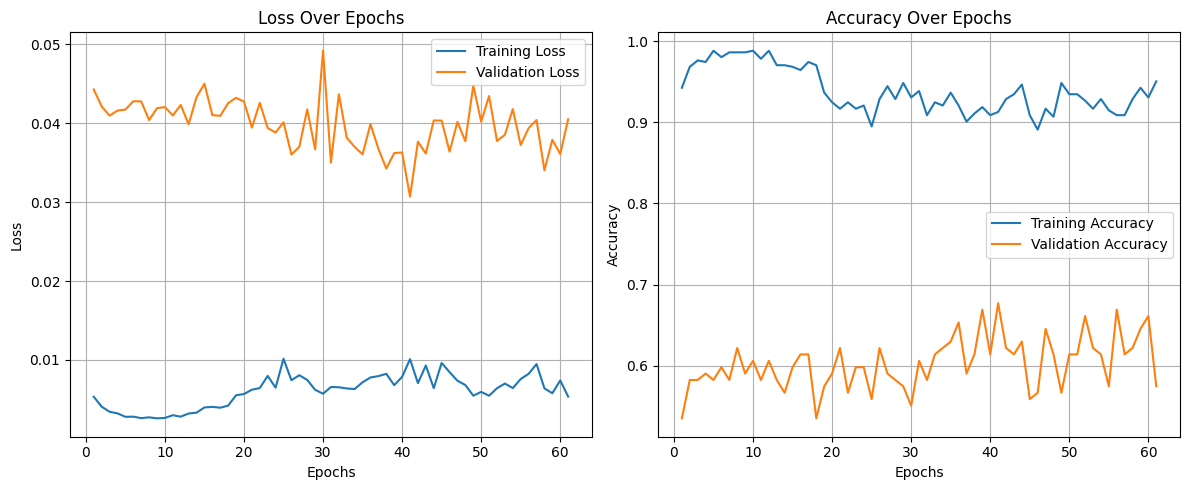


Structured Output for Post ID: 1kieckq (r/altcoin)
Title: Unknown
{
  "topic_classification": "Cryptocurrency",
  "topic_explanation": "The post is about a cryptocurrency named WhiteRock (WHITE).",
  "sentiment_score": 4,
  "sentiment_explanation": "The sentiment of the post is positive. The author expresses optimism about the potential growth of WhiteRock and encourages readers to research it further.",
  "thoughts": [
    {
      "quoted_chunk": "As of May 9, 2025, the current price of WhiteRock (WHITE) is approximately $0.000575 USD",
      "thought_classification": "Fact",
      "thought_classification_explanation": "The statement provides factual information about the current price of WhiteRock.",
      "thought_sentiment": 3,
      "positivity": true,
      "thought_sentiment_explanation": "The sentiment of the fact is neutral."
    },
    {
      "quoted_chunk": "The token has experienced a 12.89% increase in the last 24 hours",
      "thought_classification": "Fact",
      "th

In [6]:
# Cell 2: Model Loading, Prediction, and Plotting
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

DATA_FILE = "reddit_data.pkl"
MODEL_FILE = "BabyLlama.pkl"
HISTORY_FILE = "training_history.pkl"

if not os.path.exists(DATA_FILE):
    print(f"No processed data found at {DATA_FILE}. Run the embedding generation cell first.")
elif not os.path.exists(MODEL_FILE):
    print(f"No trained model found at {MODEL_FILE}. Run the training cell first.")
elif not os.path.exists(HISTORY_FILE):
    print(f"No training history found at {HISTORY_FILE}. Run the training cell first.")
else:
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
    df_test = data.get('df_test', pd.DataFrame())
    X_test = data.get('X_test', np.array([]))
    y_test = data.get('y_test', np.array([]))

    with open(HISTORY_FILE, 'rb') as f:
        history = pickle.load(f)

    if df_test.empty or X_test.size == 0:
        print("No test data available. Check preprocessing steps.")
    else:
        model = Model.load(MODEL_FILE)
        predictions = model.predict(X_test)
        # Reverse normalization for predictions (back to [1, 5])
        predictions = predictions * 4 + 1
        df_test['predicted_sentiment'] = predictions.flatten()

        print("\nTest DataFrame with Predictions:")
        print(df_test[['id', 'subreddit', 'title', 'sentiment_score', 'predicted_sentiment']].to_string(index=False))

        epochs_range = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if not df_test.empty:
            example_post_id = df_test['id'].iloc[0]
            result_row = df_test[df_test['id'] == example_post_id]
            if not result_row.empty:
                llm_result = result_row['llm_result'].iloc[0]
                subreddit = result_row.get('subreddit', 'Unknown').iloc[0]
                print(f"\nStructured Output for Post ID: {example_post_id} (r/{subreddit})")
                print(f"Title: {result_row['title'].iloc[0]}")
                print(json.dumps(llm_result, indent=2))

Cache file reddit_data.pkl exists


In [10]:
import os
cache_file = "reddit_data.pkl"
if os.path.exists(cache_file):
    print(f"Cache file {cache_file} exists")
else:
    print(f"No cache file found at {cache_file}")


import pickle
import pandas as pd
try:
    with open(cache_file, 'rb') as f:
        data = pickle.load(f)
    total_posts = len(data['df_train']) + len(data['df_test'])
    print(f"Total cached posts: {total_posts}")
    print(f"Training posts: {len(data['df_train'])}")
    print(f"Test posts: {len(data['df_test'])}")
except FileNotFoundError:
    print("Cache file not found")
except Exception as e:
    print(f"Error loading cache: {e}")

Cache file reddit_data.pkl exists
Total cached posts: 631
Training posts: 504
Test posts: 127


Reshaped y_train and y_test to 1D arrays
Normalized sentiment scores to [0, 1]
After cleaning: 492 train samples, 125 test samples

Fold 1
epoch: 1
step: 0, acc: 0.250, loss: 1.432, (data_loss: 0.289, reg_loss: 1.143), lr: 0.0001
step: 24, acc: 0.000, loss: 1.341, (data_loss: 0.489, reg_loss: 0.853), lr: 9.999760005759862e-05
training, acc: 0.023, loss: 1.224, (data_loss: 0.382, reg_loss: 0.843), lr: 9.999760005759862e-05
validation, acc: 0.020, loss: 0.386
Epoch 1, Train Loss: 0.3644, Val Loss: 0.3856, Train Acc: 0.0229, Val Acc: 0.0202
epoch: 1
step: 0, acc: 0.250, loss: 1.107, (data_loss: 0.265, reg_loss: 0.843), lr: 9.999750006249845e-05
step: 24, acc: 0.000, loss: 1.074, (data_loss: 0.439, reg_loss: 0.636), lr: 9.999510024008825e-05
training, acc: 0.023, loss: 0.975, (data_loss: 0.346, reg_loss: 0.629), lr: 9.999510024008825e-05
validation, acc: 0.030, loss: 0.343
Epoch 2, Train Loss: 0.3212, Val Loss: 0.3434, Train Acc: 0.0280, Val Acc: 0.0303
epoch: 1
step: 0, acc: 0.250, loss: 

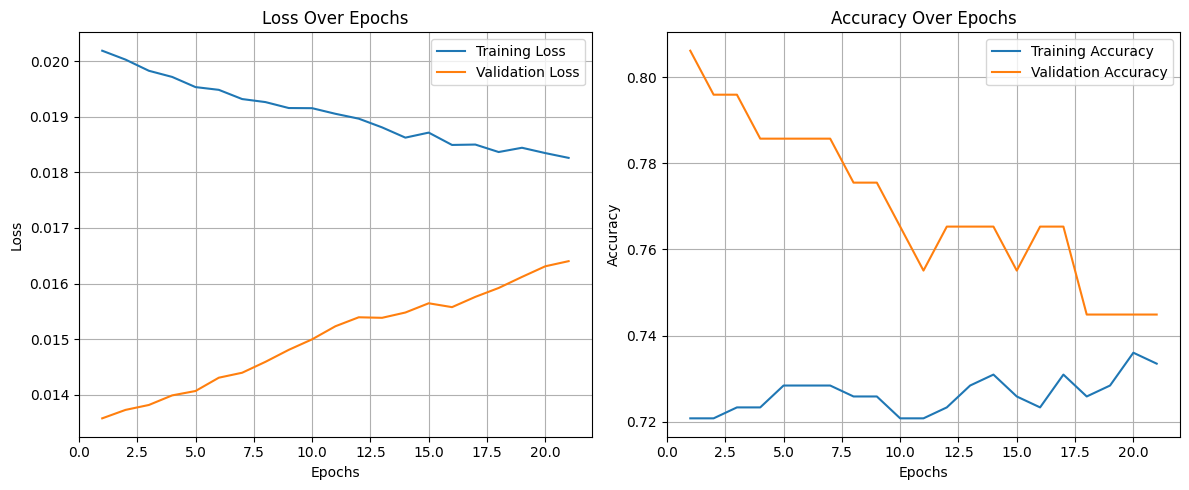


Structured Output for Post ID: 1kieckq (r/altcoin)
Title: Unknown
{
  "topic_classification": "Cryptocurrency",
  "topic_explanation": "The post is about a cryptocurrency named WhiteRock (WHITE).",
  "sentiment_score": 4,
  "sentiment_explanation": "The sentiment of the post is positive. The author expresses optimism about the potential growth of WhiteRock and encourages readers to research it further.",
  "thoughts": [
    {
      "quoted_chunk": "As of May 9, 2025, the current price of WhiteRock (WHITE) is approximately $0.000575 USD",
      "thought_classification": "Fact",
      "thought_classification_explanation": "The statement provides factual information about the current price of WhiteRock.",
      "thought_sentiment": 3,
      "positivity": true,
      "thought_sentiment_explanation": "The sentiment of the fact is neutral."
    },
    {
      "quoted_chunk": "The token has experienced a 12.89% increase in the last 24 hours",
      "thought_classification": "Fact",
      "th

In [8]:
# Cell 1: Neural Network Training with K-Fold Cross-Validation
import pickle
import os
import numpy as np
from sklearn.model_selection import KFold

DATA_FILE = "reddit_data.pkl"
epochs = 200
patience = 20

# Best architecture from previous run
architecture = [
    Layer_Dense(768, 256, weight_regularizer_l2=0.01, weight_regularizer_l1=5e-4),
    Activation_ReLU(),
    Layer_Dropout(0.5),
    Layer_Dense(256, 128, weight_regularizer_l2=0.01, weight_regularizer_l1=5e-4),
    Activation_ReLU(),
    Layer_Dense(128, 1, weight_regularizer_l2=0.01, weight_regularizer_l1=5e-4),
    Activation_Linear()
]

if not os.path.exists(DATA_FILE):
    print(f"No processed data found at {DATA_FILE}. Run the embedding generation cell first.")
else:
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
    X_train, y_train, X_test, y_test, df_train, df_test = (
        data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['df_train'], data['df_test']
    )

    if len(y_train.shape) > 1:
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        print("Reshaped y_train and y_test to 1D arrays")

    # Normalize sentiment scores to [0, 1]
    y_train = (y_train - 1) / 4
    y_test = (y_test - 1) / 4
    print("Normalized sentiment scores to [0, 1]")

    # Data cleaning
    valid_mask = (y_train >= 0) & (y_train <= 1) & (~np.isnan(y_train))
    X_train, y_train, df_train = X_train[valid_mask], y_train[valid_mask], df_train[valid_mask]
    valid_mask = (y_test >= 0) & (y_test <= 1) & (~np.isnan(y_test))
    X_test, y_test, df_test = X_test[valid_mask], y_test[valid_mask], df_test[valid_mask]
    valid_mask = df_train['llm_result'].apply(lambda x: len(x['thoughts']) > 0)
    X_train, y_train, df_train = X_train[valid_mask], y_train[valid_mask], df_train[valid_mask]
    valid_mask = df_test['llm_result'].apply(lambda x: len(x['thoughts']) > 0)
    X_test, y_test, df_test = X_test[valid_mask], y_test[valid_mask], df_test[valid_mask]
    print(f"After cleaning: {len(y_train)} train samples, {len(y_test)} test samples")

    if X_train.size == 0 or X_test.size == 0:
        print("No valid training or test data available. Check preprocessing steps.")
    else:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        best_val_loss = float('inf')
        best_model = None
        best_history = None
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"\nFold {fold+1}")
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            model = Model()
            for layer in architecture:
                model.add(layer)
            model.set(
                loss=Loss_MeanSquaredError(),
                optimizer=Optimizer_Adam(learning_rate=0.0001, decay=1e-6, clipnorm=0.5),
                accuracy=Accuracy_Regression(tolerance=0.125)
            )
            model.finalize()
            history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
            fold_best_val_loss = float('inf')
            patience_counter = 0
            for epoch in range(epochs):
                model.train(X_fold_train, y_fold_train, epochs=1, batch_size=16, print_every=1000, validation_data=(X_fold_val, y_fold_val))
                train_loss = np.mean(model.loss.forward(model.forward(X_fold_train, training=False), y_fold_train))
                val_loss = np.mean(model.loss.forward(model.forward(X_fold_val, training=False), y_fold_val))
                train_acc = model.accuracy.calculate(model.forward(X_fold_train, training=False), y_fold_train)
                val_acc = model.accuracy.calculate(model.forward(X_fold_val, training=False), y_fold_val)
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['train_acc'].append(train_acc)
                history['val_acc'].append(val_acc)
                print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
                if np.isnan(train_loss) or np.isnan(val_loss):
                    print("NaN detected, stopping fold")
                    break
                if val_loss < fold_best_val_loss:
                    fold_best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
            if fold_best_val_loss < best_val_loss:
                best_val_loss = fold_best_val_loss
                best_model = model
                best_history = history
                best_model.save("BabyLlama.pkl")
                with open('training_history.pkl', 'wb') as f:
                    pickle.dump(best_history, f)
                print("New best model saved")

        print(f"\nBest Validation Loss: {best_val_loss:.4f}")



        # Cell 2: Model Loading, Prediction, and Plotting
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

DATA_FILE = "reddit_data.pkl"
MODEL_FILE = "BabyLlama.pkl"
HISTORY_FILE = "training_history.pkl"

if not os.path.exists(DATA_FILE):
    print(f"No processed data found at {DATA_FILE}. Run the embedding generation cell first.")
elif not os.path.exists(MODEL_FILE):
    print(f"No trained model found at {MODEL_FILE}. Run the training cell first.")
elif not os.path.exists(HISTORY_FILE):
    print(f"No training history found at {HISTORY_FILE}. Run the training cell first.")
else:
    with open(DATA_FILE, 'rb') as f:
        data = pickle.load(f)
    df_test = data.get('df_test', pd.DataFrame())
    X_test = data.get('X_test', np.array([]))
    y_test = data.get('y_test', np.array([]))

    with open(HISTORY_FILE, 'rb') as f:
        history = pickle.load(f)

    if df_test.empty or X_test.size == 0:
        print("No test data available. Check preprocessing steps.")
    else:
        model = Model.load(MODEL_FILE)
        predictions = model.predict(X_test)
        # Reverse normalization for predictions (back to [1, 5])
        predictions = predictions * 4 + 1
        df_test['predicted_sentiment'] = predictions.flatten()

        print("\nTest DataFrame with Predictions:")
        print(df_test[['id', 'subreddit', 'title', 'sentiment_score', 'predicted_sentiment']].to_string(index=False))

        epochs_range = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if not df_test.empty:
            example_post_id = df_test['id'].iloc[0]
            result_row = df_test[df_test['id'] == example_post_id]
            if not result_row.empty:
                llm_result = result_row['llm_result'].iloc[0]
                subreddit = result_row.get('subreddit', 'Unknown').iloc[0]
                print(f"\nStructured Output for Post ID: {example_post_id} (r/{subreddit})")
                print(f"Title: {result_row['title'].iloc[0]}")
                print(json.dumps(llm_result, indent=2))